# Battery Cycling Simulations

This notebook demonstrates how to use the Thevenin model to simulate a variety of cycling experiments that are implemented in `sox`. The Thevenin battery model uses [PyBaMM](https://docs.pybamm.org/en/latest/index.html) in the backend, and adds abstractions for easier user interface.

In [1]:
from sox.plant import Thevenin, default_thevenin_inputs
import sox.plant.protocol as protocol
from sox.utils import quick_plot

## Cycling Protocols
There are a handful of cycling protocols that are implemented in the `sox.plant.protocol` module. These protocols are used to simulate the cycling experiments. The protocols are: 

- `cc_charge_cv_rest` (CC charge, CV hold, then rest)
- `cc_discharge_rest` (CC discharge then rest)
- `charge_discharge_cycling` (combination of 1+2 with multiple cycles)
- `single_pulse` (CC charge or discharge pulse, then rest)
- `single_pulse_train` (a train of CC pulses with a single C rate, then rest)
- `multi_pulse_train` (a train of CC pulses with multiple C rates, then rest)
- `dst_schedule` (dynamic stress test schedule)

In [2]:
# changes default initial soc
default_thevenin_inputs.initial_soc = 0.5

# builds a battery equivalent circuit model
battery = Thevenin(default_thevenin_inputs)

## Perform Simulations
We here build experiment objects from protocols and simulate battery response by passing experiments to the `battery` object as in `battery.solve(experiment)`. 

The result is a simulation object with the following properties: `time`, `voltage`, `rc_voltage`, `ocv`, `current`,
`power`, `resistance`, `series_resistance`, `rc_resistance`, `rc_capacitance`, `soc`, `ambient_temperature`,
`cell_temperature`, `jig_temperature`

In [3]:
experiments = [
    # 1. constant current then constant voltage charge, then rest
    protocol.cc_charge_cv_rest(c_rate=2.0, cv_hold_c_rate_limit=1 / 6, rest_time_h=0.1),
    # 2. constant current discharge, then rest
    protocol.cc_discharge_rest(),
    # 3. constant current charge and discharge cycling
    protocol.charge_discharge_cycling(direction="charge", number_of_cycles=3),
    # 4. constant current discharge pulse, then rest
    protocol.single_pulse(direction="discharge", c_rate=2.0, pulse_time_sec=60, pulse_rest_time_sec=120),
    # 5. one type of constant current discharge pulses back-to-back, with rest in between
    protocol.single_pulse_train(direction="discharge", number_of_pulses=15),
    # 6. two types of constant current discharge pulses back-to-back, with rest in between
    protocol.multi_pulse_train(
        direction=["discharge", "discharge"],
        c_rate=[1.0, 0.2],
        pulse_time_sec=[60, 600],
        pulse_rest_time_sec=[600, 600],
        number_of_pulses=9,
    ),
    # 7. three types of constant current charge and discharge pulses back-to-back, with rest in between
    protocol.multi_pulse_train(
        direction=["discharge", "charge", "discharge"],
        c_rate=[1.0, 1.0, 0.2],
        pulse_time_sec=[60, 60, 600],
        pulse_rest_time_sec=[600, 600, 600],
        number_of_pulses=10,
    ),
    # 8. DST (dynamic stress test) protocol
    protocol.dst_schedule(
        peak_power=3.8 * (6 * 10),
        number_of_cycles=5,
        sampling_time_s=1,
    ),
]

# simulates the experiments
solutions = [battery.solve(e) for e in experiments]

## Compare Results

Utility function `quick_plot` can be used to create interactive graphs of electrical and thermal battery parameters.

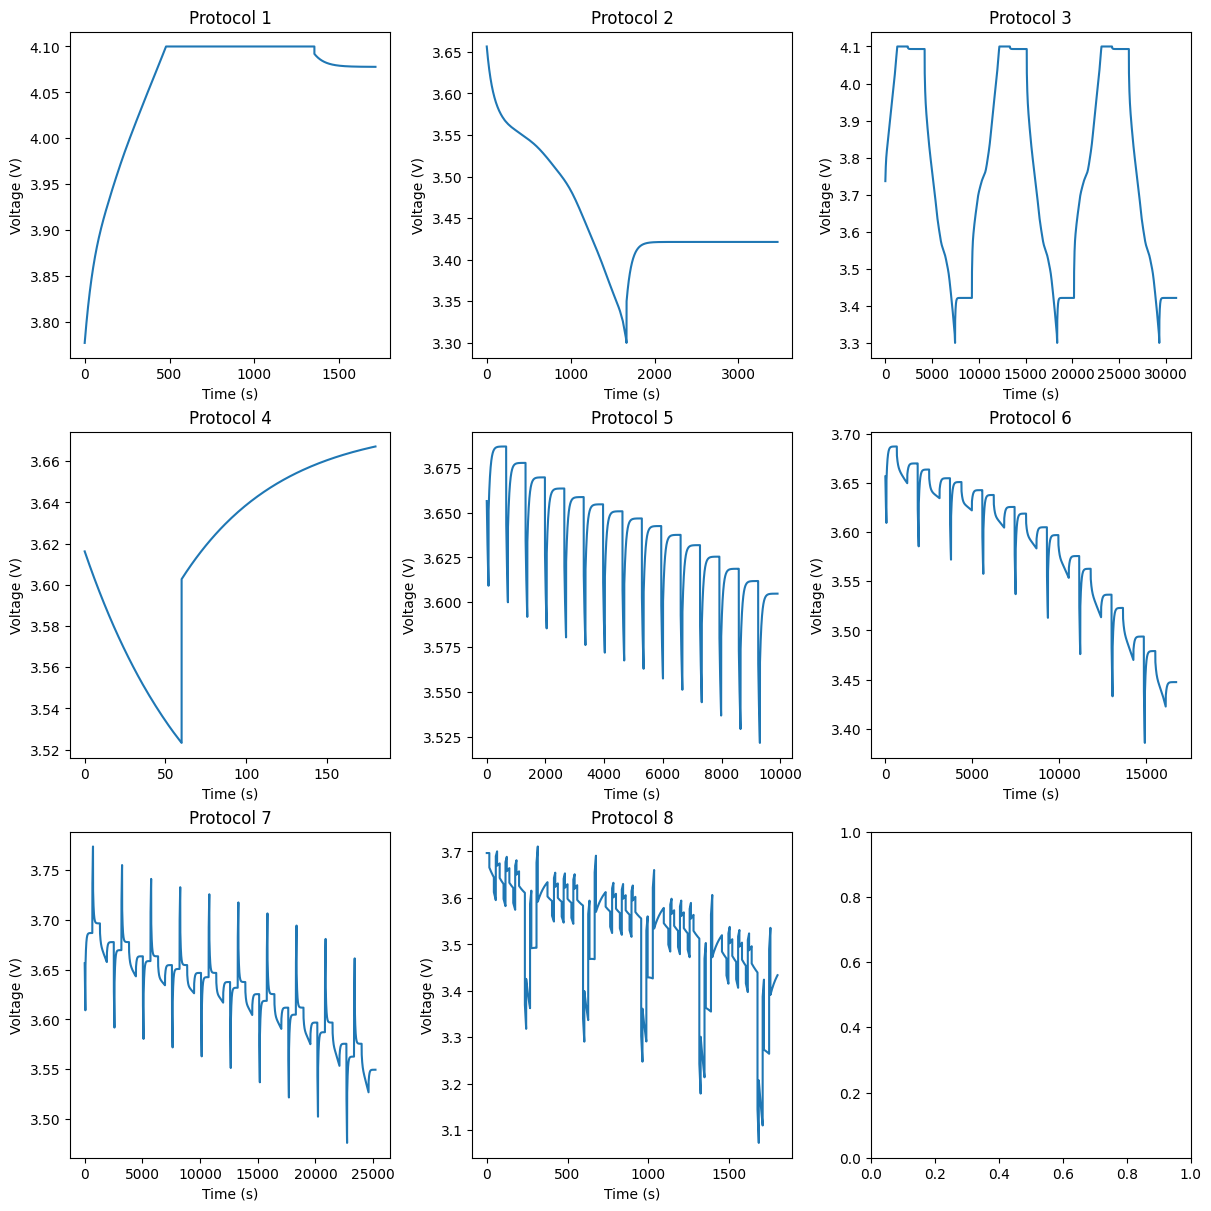

In [4]:
# generates voltage profile of all protocols

quick_plot(
    time=[sol.time for sol in solutions],
    data=[sol.voltage for sol in solutions],
    titles=[f"Protocol {j+1}" for j in range(len(solutions))],
    x_labels="Time (s)",
    y_labels="Voltage (V)",
    n_cols=3,
)

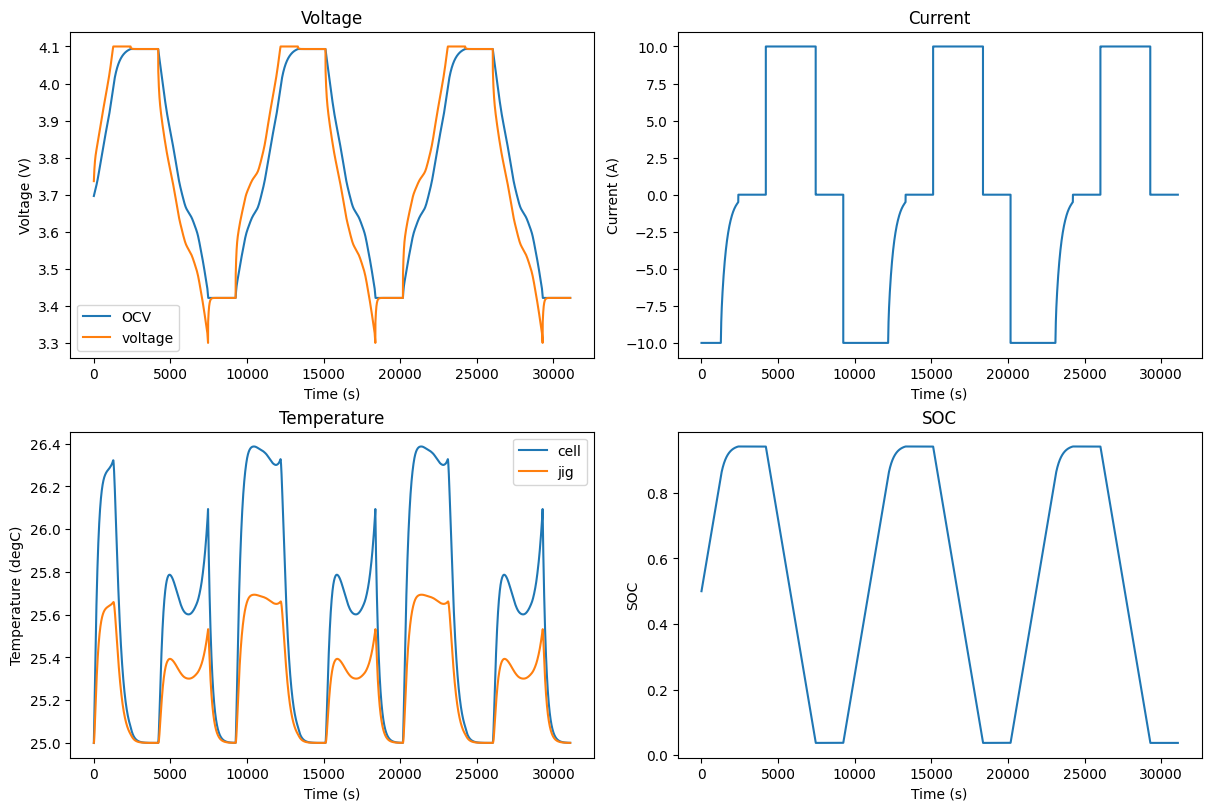

In [5]:
# generates voltage, current, temperature, and soc graphs for a single protocol

sol = solutions[2]
quick_plot(
    time=[sol.time],
    data=[[sol.ocv, sol.voltage], sol.current, [sol.cell_temperature, sol.jig_temperature], sol.soc],
    legends=[["OCV", "voltage"], "current", ["cell", "jig"], "soc"],
    x_labels="Time (s)",
    y_labels=["Voltage (V)", "Current (A)", "Temperature (degC)", "SOC"],
    titles=["Voltage", "Current", "Temperature", "SOC"],
)